# Retrieve, sort and transform datas
The download of Corel-10K may take some time because their servers are really bad

In [0]:
#get entire Corel10K
!wget http://www.ci.gxnu.edu.cn/cbir/Corel.zip
!unzip Corel.zip
!mv Corel100类库 origin

In [0]:
from PIL import Image
import os
import shutil
import random

path = "origin/"
dest = "datas/"

!rm -fr $dest
os.mkdir(dest)

def make_square(im, min_size=256, fill_color=(0, 0, 0, 0)):
    x, y = im.size
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

imgs = os.listdir(path)
count = 0
for img in imgs:
  if(img[0] == "T"):
    continue

  i = Image.open(path + img)
  ni = make_square(i, 224)
  ni.save(dest + img)

  print(count, "/", len(imgs))
  count += 1


# Create a random sample of Corel-10K (OPTIONAL)
15 imgs per classes, 100 classes

In [0]:
import os
import random
import shutil

imgs = os.listdir("datas")
results = {}
id = ''

for img in imgs:
  if (img[0] == 'T'):
    continue

  id = img[:img.find('_')]

  if id in results:
    results[id].append(img)
  else:
    results[id] = [img]

!rm -fr datas_sample
os.mkdir('datas_sample')

for key, value in results.items():
  picked = random.sample(value, 15)
  for i in picked:
    shutil.copy('datas/' + i, 'datas_sample/' + i)
    print(i)

#Create all the descriptors and save them in a Json file

Fairly quick here

Change Path to try on sample datas (not necessary since it's quick on the whole base)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transform

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import copy
import sys
import time
import os

import json

#retrieve image list
import time
t0= time.clock()
path = "datas/"
imgs = os.listdir(path)

results = {}

#using gpu if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Retrieving squeezenet pretrained + modifing it
model = torch.hub.load('pytorch/vision:v0.5.0', 'squeezenet1_0', pretrained=True)

#for each image
count = 0
for img in imgs:
  #tell the model to not update its gradients and to only evaluate the input
  with torch.no_grad():
    model.to(device)
    model.eval()

    #transform the image to fit the Squeezenet format
    transforms = transform.Compose([transform.Resize((224, 244)), transform.ToTensor(), transform.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    i = Image.open(path + img)
    tensor = transforms(i).unsqueeze_(0).to(device)

    #process the output, apply a softmax and add the descriptor to the results
    output = model(tensor)
    outputt = torch.nn.functional.softmax(output[0], dim=0)
    results[img] = output.tolist()
    print(count, "/", len(imgs))
    count += 1

#save the results
f = open('results.json', 'w')
f.write(json.dumps(results))
f.close()

#display the time elapsed
print(time.clock() - t0)



#CBIR 
read at the end of the file to change the test image

"\nfor key, value in list(datas.items()):\n  r = compare_all(datas, value)[1][0]\n  \n  ck = key[:key.find('_')]\n  cr = r[:r.find('_')]\n  \n  if cr == ck:\n    res += 1\n\n  count += 1\n  print(res/count)\n\nprint(res/len(datas))\n"

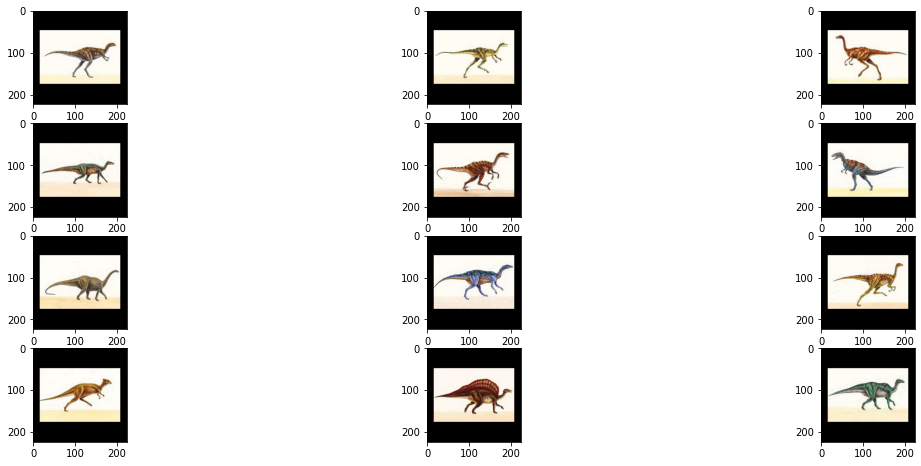

In [14]:
import json
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

datas = {}
with open("results.json") as file:
    datas = json.load(file)

for key in datas.keys():
  datas[key] = datas[key][0]

def compare(itm, lst):
  res = 0

  a = torch.Tensor(itm).to(device)
  b = torch.Tensor(lst).to(device)

  c = a - b
  c = c.abs()

  return c.sum()

def compare_all(datas, lst):
  res = []

  for key, value in datas.items():
    res.append([key, compare(lst, value)])
  
  return sorted(res, key = lambda x: x[1])

res = 0
count = 0

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#compare to the first image, change the 0 to compare to another image
key, value = list(datas.items())[0]

r = compare_all(datas, value)[0:12]
images = []

#display 12 first images
for i in r:
  name = i[0]
  img = mpimg.imread("datas/"+name)
  images.append(img)

plt.figure(figsize=(20,10))
columns = 3
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

#precision on the whole base
"""
for key, value in list(datas.items()):
  r = compare_all(datas, value)[1][0]
  
  ck = key[:key.find('_')]
  cr = r[:r.find('_')]
  
  if cr == ck:
    res += 1

  count += 1
  print(res/count)

print(res/len(datas))
"""
  
  